In [1]:
import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 1
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('../report_plots/report.mplstyle')

# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')


import warnings
warnings.simplefilter('ignore')

PyTorch version: 1.13.1+cu117
Using device: cuda:1


# Figure 5

In [2]:
mouse_id = 'Mouse12'
session_id = '120806'
phase = 'wake'
subset = 'hdc'

bin_size = 20  # ms
single_spikes = False

delay = 0
batch_size = 1000  # size of time segments of each batch in dataset below
cv_run = -1


checkpoint_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/checkpoint/'
data_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/' 

dataset_dict = HDC.get_dataset(mouse_id, session_id, phase, subset, bin_size, 
                                               single_spikes, path=data_dir)

model_dict = {
                'seed': 123, 
                'll_mode': 'U-eq-2',  # stands for universal count model with exponential-quadratic expansion and C = 3
                'filt_mode': '',  # GLM couplings
                'map_mode': 'svgp-64',  # a sparse variational GP mapping with 64 inducing points
                'x_mode': 'hd',  # observed covariates (behaviour)
                'z_mode': '',  # latent covariates
                'hist_len': 0, 
                'folds': 5, 
                'delays': [0], 
                'neurons': dataset_dict['neurons'], 
                'max_count': dataset_dict['max_count'], 
                'bin_size': dataset_dict['bin_size'], 
                'tbin': dataset_dict['tbin'], 
                'model_name': dataset_dict['name'], 
                'tensor_type': torch.float, 
                'jitter': 1e-4, 
            }

units_used = dataset_dict['neurons']
rcov = np.empty((0, dataset_dict['covariates']['hd'].shape[0]))

for cov in ['hd', 'omega', 'speed', 'x', 'y', 'time']:
    rcov = np.concatenate((rcov, dataset_dict['covariates'][cov][None, :]), axis=0)
 

hd_sweep = torch.linspace(0, 2*np.pi, 100)

covariates = torch.cat([
    hd_sweep[:, None],  # sweep over head direction
    *[rcov[k].mean()*torch.ones((100, 1)) for k in range(1, len(rcov))], 
    # fill other behavioural covariates at value 0
], dim=-1)[None, None, ...]  # (tr, neurons, steps, covariate dims)


rcov = dataset_dict['covariates']
sweep = torch.linspace(0, 2*torch.pi, 100)[None, :]
rcov_matrix = [torch.tensor(rcov[k]) for k in rcov.keys()]

units:  85  hdc units:  22


In [3]:
delays = [-3, -2, -1, 0, 1, 2, 3]
model_dict['delays'] = delays
likelihoods = []


for i, delay in enumerate(delays):
    if i == 3:
        continue
    modelfit, training_results, fit_set, validation_set = lib.models.load_model(
        checkpoint_dir, model_dict, dataset_dict, HDC.enc_used, 
        delay, cv_run, batch_size, gpu_dev)

    ll = lib.helper.RG_pred_ll(
                    modelfit, fit_set, neuron_group=None, ll_mode='MC', 
                    ll_samples=1, cov_samples=1, beta=0.0)
    likelihoods.append(ll)

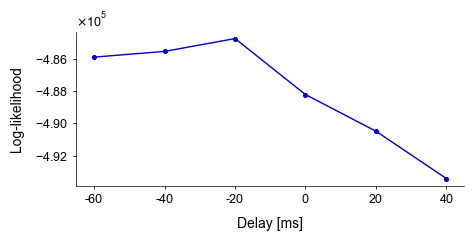

In [10]:
fig, ax = plt.subplots(figsize=(5,2))

colors = ['mediumblue', 'crimson']


ax.plot(np.arange(-3, 3), likelihoods, color=colors[0], linewidth=1)
ax.scatter(np.arange(-3, 3), likelihoods, color=colors[0], s=7)

ax.set_ylabel('Log-likelihood')
ax.set_xlabel('Delay [ms]')
ax.set_xticklabels([0, -60, -40, -20, 0, 20, 40])
ax.spines[['right', 'top']].set_visible(False)
ax.yaxis.get_major_formatter().set_scientific('%.2e')
ax.yaxis.get_major_formatter().set_powerlimits((0,0))
ax.yaxis.get_major_formatter().set_useMathText(True)

ax.tick_params(axis='x')
ax.tick_params(axis='y')

fig.savefig("/homes/vn283/UCM-interpret/figures/time_delay.pdf", format="pdf", bbox_inches="tight")